In [1]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import torch

from collections import OrderedDict
from datasets import load_dataset
from nltk.tokenize import ToktokTokenizer
from sklearn.metrics import f1_score
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

# Deep Average Network для определения сентимента 

В этой домашке мы будет классифицировать твиты на 3 тональности.  
Вы будете использовать предобученные эмбеддинги слов, так что для начала обязательно нужно посмотреть [туториал по их использованию](https://github.com/BobaZooba/DeepNLP/blob/master/Tutorials/Word%20vectors%20%26%20Data%20Loading.ipynb).

Наши классы:  

Индекс | Sentiment  
-- | --  
0 | negative  
1 | neutral  
2 | positive  

Вам предстоит реализовать такую модель:
![Архитектура модели DAN](https://www.researchgate.net/profile/Shervin-Minaee/publication/340523298/figure/fig1/AS:878252264550411@1586403065555/The-architecture-of-the-Deep-Average-Network-DAN-10.ppm)

Что она из себя представляет:
- Мы подаем в нее индексы слов
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`

В этой домашке вам предстоит:
- Перевести тексты в матрицы с индексами токенов
- Реализовать модель
- Обучить ее
- Понять хорошо ли вы это сделали

Это очень важная модель, потому что она очень простая и показывает достаточно высокие метрики. В дальнейшем на работе советую использовать такую модель как бейзлайн. И в качестве эмбеддингов слов взять эмбеддинги от берта/роберты/тд.

## 🤗 Datasets
В этом туториале мы будем использовать подготовленные данные из библиотеки [datasets](https://github.com/huggingface/datasets). Мы вряд ли еще будем пользоваться этой библиотекой, так как нам будет важно самим подготавливать данные. Во-первых, для простоты, во-вторых, здесь есть достаточно неплохие практики. [Здесь](https://huggingface.co/datasets) вы сможете найти достаточно большое количество различных датасетов. Возможно, когда-нибудь они вам пригодятся.

## Загрузите эмбеддинги слов
Реализуйте функцию по загрузке эмбеддингов из файла. Она должна отдавать словарь слов и `np.array`
Формат словаря:
```python
{
    'aabra': 0,
    ...,
    'mom': 6546,
    ...
    'xyz': 100355
}
```
Формат матрицы эмбеддингов:
```python
array([[0.44442278, 0.28644582, 0.04357426, ..., 0.9425766 , 0.02024289,
        0.88456545],
       [0.77599317, 0.35188237, 0.54801261, ..., 0.91134102, 0.88599103,
        0.88068835],
       [0.68071886, 0.29352313, 0.95952505, ..., 0.19127958, 0.97723054,
        0.36294011],
       ...,
       [0.03589378, 0.85429694, 0.33437761, ..., 0.39784873, 0.80368014,
        0.76368042],
       [0.01498725, 0.78155695, 0.80372969, ..., 0.82051826, 0.42314861,
        0.18655465],
       [0.69263802, 0.82090775, 0.27150426, ..., 0.86582747, 0.40896573,
        0.33423976]])
```

Количество строк в матрице эмбеддингов должно совпадать с размером словаря, то есть для каждого токена должен быть свой эмбеддинг. По параметру `num_tokens` должно брать не более указано в этом параметре количество токенов в словарь и матрицу эмбеддингов.

In [2]:
# !wget  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
# !gzip -d cc.ru.300.vec.gz

In [3]:
def load_embeddings(path='cc.ru.300.vec', num_tokens=100_000, pad_token='PAD', unk_token='UNK'):
    """
    
    """
    # Необязательно задавать здесь
    # Это рекомендация к типу
    token2index: Dict[str, int] = {}
    embeddings_matrix: np.array = []
    
    with open(path, 'r') as f:
        vocab_size, embedding_dim = f.readline().strip().split()
        
        vocab_size = int(vocab_size)
        embedding_dim = int(embedding_dim)

        if num_tokens <= 0:
            num_tokens = vocab_size


        # добавим пад токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        token2index[pad_token] = 0
        embeddings_matrix.append(np.zeros(embedding_dim))

        # добавим унк токен и эмбеддинг в нашу матрицу эмбеддингов и словарь
        token2index[unk_token] = 1
        embeddings_matrix.append(np.ones(embedding_dim))
       
        for line in f:
            parts = line.strip().split()

            token = ' '.join(parts[:-embedding_dim]).lower()

            if token not in token2index:

                word_vector = np.array(list(map(float, parts[-embedding_dim:])))

                token2index[token] = len(token2index)
                embeddings_matrix.append(word_vector)

                if len(token2index) == num_tokens:
                    break
                    
    embeddings_matrix = np.stack(embeddings_matrix)
    
    assert(len(token2index) == embeddings_matrix.shape[0])
    
    return token2index, embeddings_matrix

## Загружаем данные из библиотеки
Мы сразу получим `torch.utils.data.Dataset`, который сможем передать в `torch.utils.data.DataLoader`

In [4]:
dataset_path = "tweet_eval"
dataset_name = "sentiment"

train_dataset = load_dataset(path=dataset_path, name=dataset_name, split="train")
valid_dataset = load_dataset(path=dataset_path, name=dataset_name, split="validation")
test_dataset = load_dataset(path=dataset_path, name=dataset_name, split="test")

Reusing dataset tweet_eval (/Users/humonen/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/Users/humonen/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)
Reusing dataset tweet_eval (/Users/humonen/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


## `torch.utils.data.DataLoader`

In [5]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

## Посмотрим что отдает нам `Loader`
Это батч формата:
```python
batch = {
    "text": [
        "text1",
        "text2",
        ...,
        "textn"
    ],
    "label": tensor([
        1,
        1,
        ...,
        0
    ])
}
```
То есть у нас есть словарь с двумя ключами `text` и `label`, где хранится n примеров. То есть для 5-го примера в батче текст будет храниться в `batch["text"][5]`, а индекс класса будет храниться в `batch["label"][5]`.

In [6]:
for batch in train_loader:
    break

batch

{'text': ["Prince George's latest outing at the beach may be his cutest one yet!",
  "Anyone going to the October 3rd MSG show with BROCK LESNAR that'll air LIVE on #WWENetwork? #WWE #Raw"],
 'label': tensor([2, 1])}

## Collate
Сейчас перед нами стоит проблема: мы получаем тексты в виде строк, а нам нужны тензоры (матрицы) с индексами токенов, к тому же нам нужно западить последовательности токенов, чтобы все сложить в торчовую матрицу. Мы можем сделать это двумя способами:
- Достать из `train/valid/test_dataset` данные и написать свой `Dataset`, где внутри будет токенизировать текст, токены будут переводиться в индексы и затем последовательность будет падиться до нужной длины
- Сделать функцию, которая бы дополнительно обрабатывали наши батчи. Она вставляется в `DataLoader(collate_fn=<ВАША_ФУНКЦИЯ>)`

## Если вы хотите сделать свой `Dataset`
То вы можете достать данные таким образом.

In [7]:
len(train_dataset["text"]), len(train_dataset["label"])

(45615, 45615)

In [8]:
train_dataset["text"][:2]

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"']

In [9]:
train_dataset["label"][:2]

[2, 1]

## Если вы хотите сделать `collate_fn`

### Давайте посмотрим что вообще происходит внутри этого метода
Для этого сделаем функцию `empty_collate`, которая принимает на вход батч и отдает его, ничего с ним не делая

In [10]:
def empty_collate(batch):
    return batch

In [11]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=empty_collate)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=empty_collate)

In [12]:
for batch in train_loader:
    break

batch

[{'text': 'I miss Niall so much he made me so happy on Saturday I felt at home and god I want to go back',
  'label': 2},
 {'text': '"Gonna stream Umineko again on Tuesday or Wednesday. Will probably hit the second twilight at least, I hope."',
  'label': 2}]

## Формат батча
```python
batch = [
    {
        "text": "text1",
        "label": 0
    }, 
    {
        "text": "text2",
        "label": 1
    },
    ...,
    {
        "text": "textn",
        "label": 1
    }
]
```
То есть теперь у нас есть список, где каждый элемент — это словарь со значениями `text` и `label`.  

Вы можете сделать функцию или класс с методом `collate`. Этот способ решения домашки предодчтительней, так как использовать `collate` очень хорошая практика.

Что я предлагаю:
- Сделайте класс `Tokenizer`

In [13]:
class Tokenizer:
    
    def __init__(self, base_tokenizer, token2index, pad_token, unk_token, max_length):
        
        self._base_tokenizer = base_tokenizer  # например ToktokTokenizer()
        
        self.token2index = token2index  # словарь из load_embeddings()
        
        self.pad_token = pad_token
        self.pad_index = self.token2index[self.pad_token]
        
        self.unk_token = unk_token
        self.unk_index = self.token2index[self.unk_token]
        
        self.max_length = max_length

    def tokenize(self, text):
        """
        В этом методе нужно разделить строку текста на токены
        """
        return self._base_tokenizer.tokenize(text)
    
    def indexing(self, tokenized_text):
        """
        В этом методе нужно перевести список токенов в список с индексами этих токенов
        """
        indexed = []
        for token in tokenized_text:
            if token in self.token2index:
                indexed.append(self.token2index[token])
            else:
                indexed.append(self.unk_index)
        
        return indexed
        
    def padding(self, tokens_indices):
        """
        В этом методе нужно сделать длину tokens_indices равной self.max_length
        Опционально убрать повторяющиеся unk'и
        """
        padded = []
        sequence_length = min(len(tokens_indices), self.max_length)
        
        for i in range(sequence_length):
            current = tokens_indices[i]
            if i>0 and current == self.unk_index and tokens_indices[i-1] == self.unk_index:
                pass
            else:
                padded.append(current)
    
        for i in range(self.max_length - len(padded)):
                padded.append(self.pad_index)
        
        return padded
    
    def __call__(self, text):
        """
        В этом методе нужно перевести строку с текстом в вектор с индексами слов нужно размера (self.max_length)
        """
        
        tokenized = self.tokenize(text)
        indexed = self.indexing(tokenized)
        padded = self.padding(indexed)

        return padded
        
    def collate(self, batch):
        
        tokenized_texts = list()
        labels = list()
        
        for sample in batch:
            tokenized_texts.append(self(sample['text']))
            labels.append(sample['label'])
            
        tokenized_texts = torch.tensor(tokenized_texts) # перевод в torch.Tensor
        labels = torch.tensor(labels)  # перевод в torch.Tensor
        
        return tokenized_texts, labels

## Перед реализацией выбранного метода
Советую, чтобы в итоге `Loader` отдавал кортеж с двумя тензорами:
- `torch.Tensor` с индексами токенов, размерность `(batch_size, sequence_length)`
- `torch.Tensor` с индексами таргетов, размерность `(batch_size)`

То есть, чтобы было так:
```python
for x, y in train_loader:
    ...

>> x
>> tensor([[   37,  3889,   470,  ...,     0,     0,     0],
           [ 1509,   581,   144,  ...,     0,     0,     0],
           [ 1804,   893,  2457,  ...,     0,     0,     0],
           ...,
           [  170, 39526,  2102,  ...,     0,     0,     0],
           [ 1217,   172, 28440,  ...,     0,     0,     0],
           [   37,    56,   603,  ...,     0,     0,     0]])

>> y
>> tensor([1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1,
           0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0,
           1, 0, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 2,
           2, 1, 2, 0, 2, 2, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2,
           2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 1,
           2, 1, 1, 2, 2, 1, 1, 2])

>> x.shape
>> torch.Size([128, 64])

>> y.shape
>> torch.Size([128])
```
При условии, что батч сайз равен 128, а максимальная длина последовательности равна 64.

## Помните

In [14]:
emb_path = 'cc.ru.300.vec'
num_tokens = 100_000
pad_token = 'PAD'
unk_token = 'UNK'

In [15]:
token2index, embeddings_matrix = load_embeddings(path=emb_path, 
                                                 num_tokens=num_tokens, 
                                                 pad_token=pad_token, 
                                                 unk_token=unk_token)

In [16]:
base_tokenizer = ToktokTokenizer()
max_lenght = 64
tokenizer = Tokenizer(base_tokenizer, token2index, pad_token, unk_token, max_lenght)
my_collate = tokenizer.collate

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=my_collate)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=my_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=my_collate)

In [18]:
for x, y in train_loader:
    break

In [19]:
assert(isinstance(x, torch.Tensor))
assert(len(x.size()) == 2)

assert(isinstance(y, torch.Tensor))
assert(len(y.size()) == 1)

# Реализация DAN

На вход модели будут подавать индексы слов

Шаги:
- Переводим индексы слов в эмбеддинги
- Усредняем эмбеддинги
- Пропускаем усредненные эмбеддинги через `Multilayer Perceptron`
    - Нужно реализовать самому
    
Дополнительно:
- Добавьте `nn.Dropout`, `nn.BatchNorm` по вкусу
- Сделайте усреднение с учетом падов
- Используйте эмбеддинги от берта/роберты/тд (когда-нибудь про это будет целый туториал, а пока предлагают вам попробовать сделать это самим)

# Советы

## До обучения
- Выберите метрику(ки) качества и расскажите почему она(они)
    - Обычно есть основная метрика, по которой принимаем решения какие веса брать и дополнительные, которые нам помогут делать выводы, например, о том все ли хорошо с нашими данными, хорошо ли модель справляется с дисбалансом классов и тд
- Эту домашку можно сделать и на `CPU`, но на `GPU` будет сильно быстрее
    - Во всех остальных домашках мы будем учить модели на `GPU`
    - Рано или поздно вам придется посмотреть этот [туториал](https://www.youtube.com/watch?v=pgk1zGv5lU4)
    - Вы можете обучаться на `colab`, это бесплатно

## До эпохи
- Сделайте списки/словари/другое, чтобы сохранять нужные данные для расчета метрик(и) по всей эпохе для трейна и валидации

## Во время эпохи
- Используйте [`tqdm`](https://github.com/tqdm/tqdm) как прогресс бар, чтобы понимать как проходит ваше обучение
- Логируйте лосс
- Логируйте метрику(ки) по батчу
- Сохраняйте то, что вам нужно, чтобы посчитать метрик(и) на всю эпоху для трейна и валидации

## После эпохи
- Посчитайте метрик(и) на всю эпоху для трейна и валидации

## После обучения
- Провалидируйтесь на тестовом наборе и посмотрите метрики
- Постройте [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- Постройте графики:
    - [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
    - [Опционально] Распределение вероятностей мажоритарного класса (то есть для какого-то примера мы выбираем такой класс и вероятность этого выбора такая-то) на трейне/тесте/валидации
        - Если класс был выбран верно и если была ошибка
- Подумайте что еще вам будет полезно для того, чтобы ответить на такие вопросы: 
    - Что в моделе можно улучшить?
    - Все ли хорошо с моими данными?
    - Все ли хорошо с валидацией?
    - Не переобучился ли я?
    - Достаточно ли я посмотрел на данные?
    - Нужно ли мне улучшить предобработку данных?
    - Нужно ли поменять токенизацию или эмбеддинги?
    - Нет ли у меня багов в реализации?
    - Какие типичные ошибки у моей модели?
    - Как я могу их исправить?

# Я выбрал метрику 
Почему я выбрал эту метрику:  
<РАССКАЗ_ПРО_МЕТРИКУ>

In [20]:
class DeepAverageNetwork(nn.Module):
    def __init__(self, n_layers=2, embeddings=embeddings_matrix, hidden_dim=64):
        super().__init__()
        
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.input_dim = embeddings_matrix.shape[1]
        
        self.lin_0 = nn.Linear(self.input_dim, self.hidden_dim, bias=False)
        
        lins = OrderedDict()
        for i in range(1, n_layers+1):
            lin = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
            act = nn.ReLU()
            lins[f'lin{i}'] = lin
            lins[f'act{i}'] = act
        
        self.linears = nn.Sequential(lins)
        self.lin_last = nn.Linear(self.hidden_dim, 3, bias=False)
#         self.softmax = nn.Softmax()
        
    def forward(self, batch):
        vectors = embeddings_matrix[batch]
        sentences = torch.mean(torch.tensor(vectors), dim=1)
        sentences = self.lin_0(sentences.float())
        sentences = self.linears(sentences)
        sentiment = self.lin_last(sentences)
#         sentiment = self.softmax(sentiment)
        
        return sentiment
        

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
print(device)

cpu


In [22]:
model = DeepAverageNetwork(n_layers=2)
model = model.to(device)

## Задайте функцию потерь и оптимизатор

In [23]:
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [24]:
def train(model, optimizer, criterion, iterator, device):
    #train
    epoch_loss = 0
    
    model.train()

    for X, y in tqdm(iterator):

        optimizer.zero_grad()
                
        y = y.long().to(device)
        predictions = model(X.to(device))
                
        loss = criterion(predictions, y)
        loss.backward()

        optimizer.step()

        batch_loss = loss.item()
        epoch_loss += batch_loss
        
    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, criterion, iterator, device, return_predictions=False):
    
    epoch_loss = 0

    model.eval()
    
    all_predictions = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)

    with torch.no_grad():

        for X, y in tqdm(iterator):

            y = y.long().to(device)
            predictions = model(X.to(device))

            loss = criterion(predictions, y)

            epoch_loss += loss.item()
            
            if return_predictions:
                all_predictions = torch.cat((all_predictions, predictions))
                y_true = torch.cat((y_true, y))

    overall_loss = epoch_loss / len(iterator)
    
    print(f"epoch loss {overall_loss}")
    print(
        "========================================================================================================"
    )
    if return_predictions:
        return overall_loss, {'true' : y_true, 'pred' : all_predictions}
    else:
        return overall_loss

## Сделайте цикл обучения

In [26]:
NUM_EPOCHS = 100  # Задайте количество эпох

loss = []
loss_eval = []

for n_epoch in range(NUM_EPOCHS):
    
    print(f"epoch {n_epoch}")
    loss.append(train(model, optimizer, criterion, train_loader, device))
    
    #eval
    print(f"epoch {n_epoch} evaluation")
    loss_eval.append(evaluate(model, criterion, valid_loader, device))

  1%|▎                                       | 13/1426 [00:00<00:11, 125.85it/s]

epoch 0


 29%|████████████                              | 18/63 [00:00<00:00, 176.70it/s]

epoch 0 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 156.45it/s]

epoch loss 0.990418517400348
epoch 1


 30%|████████████▋                             | 19/63 [00:00<00:00, 186.97it/s]

epoch 1 evaluation


  1%|▍                                       | 17/1426 [00:00<00:08, 159.94it/s]

epoch loss 0.9738932261391292
epoch 2


 30%|████████████▋                             | 19/63 [00:00<00:00, 183.93it/s]

epoch 2 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 156.30it/s]

epoch loss 0.98365299758457
epoch 3


 30%|████████████▋                             | 19/63 [00:00<00:00, 181.87it/s]

epoch 3 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.12it/s]

epoch loss 0.9675020367380173
epoch 4


 33%|██████████████                            | 21/63 [00:00<00:00, 202.81it/s]

epoch 4 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.93it/s]

epoch loss 0.9692113626570928
epoch 5


 27%|███████████▎                              | 17/63 [00:00<00:00, 168.10it/s]

epoch 5 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 141.90it/s]

epoch loss 0.9512807452489459
epoch 6


 29%|████████████                              | 18/63 [00:00<00:00, 175.97it/s]

epoch 6 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.19it/s]

epoch loss 0.9619941191067771
epoch 7


 30%|████████████▋                             | 19/63 [00:00<00:00, 180.82it/s]

epoch 7 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 154.84it/s]

epoch loss 0.9452930897001236
epoch 8


 27%|███████████▎                              | 17/63 [00:00<00:00, 164.39it/s]

epoch 8 evaluation


  1%|▎                                       | 13/1426 [00:00<00:10, 129.90it/s]

epoch loss 0.9469573195018466
epoch 9


 29%|████████████                              | 18/63 [00:00<00:00, 174.07it/s]

epoch 9 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 152.05it/s]

epoch loss 0.9434234358015514
epoch 10


 32%|█████████████▎                            | 20/63 [00:00<00:00, 193.49it/s]

epoch 10 evaluation


  1%|▍                                       | 16/1426 [00:00<00:08, 156.72it/s]

epoch loss 0.967440682744223
epoch 11


 30%|████████████▋                             | 19/63 [00:00<00:00, 181.03it/s]

epoch 11 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 147.25it/s]

epoch loss 0.9912454372360593
epoch 12


 30%|████████████▋                             | 19/63 [00:00<00:00, 182.68it/s]

epoch 12 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 145.81it/s]

epoch loss 0.9511338548054771
epoch 13


 27%|███████████▎                              | 17/63 [00:00<00:00, 167.19it/s]

epoch 13 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 145.39it/s]

epoch loss 0.9443446662690904
epoch 14


 29%|████████████                              | 18/63 [00:00<00:00, 178.60it/s]

epoch 14 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 151.12it/s]

epoch loss 0.9376727872424655
epoch 15


 30%|████████████▋                             | 19/63 [00:00<00:00, 181.56it/s]

epoch 15 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 146.88it/s]

epoch loss 0.9366297192043729
epoch 16


 32%|█████████████▎                            | 20/63 [00:00<00:00, 193.78it/s]

epoch 16 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 148.40it/s]

epoch loss 0.9390914676681398
epoch 17


 30%|████████████▋                             | 19/63 [00:00<00:00, 189.85it/s]

epoch 17 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 147.50it/s]

epoch loss 0.9532484913629199
epoch 18


 30%|████████████▋                             | 19/63 [00:00<00:00, 185.40it/s]

epoch 18 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 155.86it/s]

epoch loss 0.9612587245683821
epoch 19


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.05it/s]

epoch 19 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 152.64it/s]

epoch loss 0.9339665779991756
epoch 20


 30%|████████████▋                             | 19/63 [00:00<00:00, 183.52it/s]

epoch 20 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.34it/s]

epoch loss 0.9408088165616232
epoch 21


 32%|█████████████▎                            | 20/63 [00:00<00:00, 192.70it/s]

epoch 21 evaluation


  1%|▍                                       | 16/1426 [00:00<00:08, 156.97it/s]

epoch loss 0.9660602164646935
epoch 22


 30%|████████████▋                             | 19/63 [00:00<00:00, 179.75it/s]

epoch 22 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 145.87it/s]

epoch loss 0.9333826483242096
epoch 23


 29%|████████████                              | 18/63 [00:00<00:00, 170.75it/s]

epoch 23 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 142.85it/s]

epoch loss 0.9470808695233057
epoch 24


 30%|████████████▋                             | 19/63 [00:00<00:00, 183.46it/s]

epoch 24 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.85it/s]

epoch loss 0.9512187885859656
epoch 25


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.79it/s]

epoch 25 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 152.28it/s]

epoch loss 0.9310124942234584
epoch 26


 30%|████████████▋                             | 19/63 [00:00<00:00, 187.30it/s]

epoch 26 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.10it/s]

epoch loss 0.9312877049521794
epoch 27


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.16it/s]

epoch 27 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.68it/s]

epoch loss 0.9628434237979707
epoch 28


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.48it/s]

epoch 28 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 150.74it/s]

epoch loss 0.9501571115993318
epoch 29


 30%|████████████▋                             | 19/63 [00:00<00:00, 182.17it/s]

epoch 29 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.15it/s]

epoch loss 0.9304444884497022
epoch 30


 30%|████████████▋                             | 19/63 [00:00<00:00, 186.51it/s]

epoch 30 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.79it/s]

epoch loss 0.9475509032370553
epoch 31


 30%|████████████▋                             | 19/63 [00:00<00:00, 189.46it/s]

epoch 31 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 147.81it/s]

epoch loss 0.9355241959057157
epoch 32


 29%|████████████                              | 18/63 [00:00<00:00, 179.57it/s]

epoch 32 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 148.82it/s]

epoch loss 0.9328223675016373
epoch 33


 29%|████████████                              | 18/63 [00:00<00:00, 174.69it/s]

epoch 33 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 141.37it/s]

epoch loss 0.9379301790207152
epoch 34


 30%|████████████▋                             | 19/63 [00:00<00:00, 187.68it/s]

epoch 34 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 141.75it/s]

epoch loss 0.9326097397577195
epoch 35


 30%|████████████▋                             | 19/63 [00:00<00:00, 183.46it/s]

epoch 35 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.97it/s]

epoch loss 0.938159391993568
epoch 36


 29%|████████████                              | 18/63 [00:00<00:00, 178.26it/s]

epoch 36 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 146.50it/s]

epoch loss 0.9301515590576899
epoch 37


 29%|████████████                              | 18/63 [00:00<00:00, 177.89it/s]

epoch 37 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 139.73it/s]

epoch loss 0.9278638514261397
epoch 38


 30%|████████████▋                             | 19/63 [00:00<00:00, 188.21it/s]

epoch 38 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.69it/s]

epoch loss 0.9336852752973163
epoch 39


 30%|████████████▋                             | 19/63 [00:00<00:00, 185.65it/s]

epoch 39 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 143.97it/s]

epoch loss 0.946572482585907
epoch 40


 30%|████████████▋                             | 19/63 [00:00<00:00, 185.66it/s]

epoch 40 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 154.88it/s]

epoch loss 0.9484248549219162
epoch 41


 32%|█████████████▎                            | 20/63 [00:00<00:00, 189.89it/s]

epoch 41 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 154.99it/s]

epoch loss 0.945123242953467
epoch 42


 32%|█████████████▎                            | 20/63 [00:00<00:00, 190.84it/s]

epoch 42 evaluation


  1%|▍                                       | 16/1426 [00:00<00:08, 157.77it/s]

epoch loss 0.9233909703436352
epoch 43


 30%|████████████▋                             | 19/63 [00:00<00:00, 181.59it/s]

epoch 43 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.62it/s]

epoch loss 0.9309943280522786
epoch 44


 30%|████████████▋                             | 19/63 [00:00<00:00, 187.60it/s]

epoch 44 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 143.30it/s]

epoch loss 0.94928491967065
epoch 45


 32%|█████████████▎                            | 20/63 [00:00<00:00, 195.87it/s]

epoch 45 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 152.90it/s]

epoch loss 0.9462659926641555
epoch 46


 32%|█████████████▎                            | 20/63 [00:00<00:00, 189.68it/s]

epoch 46 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 155.96it/s]

epoch loss 0.9350058691842216
epoch 47


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.20it/s]

epoch 47 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.98it/s]

epoch loss 0.9317523723556882
epoch 48


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.91it/s]

epoch 48 evaluation


  1%|▍                                       | 16/1426 [00:00<00:08, 158.80it/s]

epoch loss 0.9212227037974766
epoch 49


 29%|████████████                              | 18/63 [00:00<00:00, 172.39it/s]

epoch 49 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 148.28it/s]

epoch loss 0.9370736479759216
epoch 50


 30%|████████████▋                             | 19/63 [00:00<00:00, 189.36it/s]

epoch 50 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 154.70it/s]

epoch loss 0.9582325182263813
epoch 51


 30%|████████████▋                             | 19/63 [00:00<00:00, 180.38it/s]

epoch 51 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 145.83it/s]

epoch loss 0.9296102608953204
epoch 52


 30%|████████████▋                             | 19/63 [00:00<00:00, 181.53it/s]

epoch 52 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 154.00it/s]

epoch loss 0.9576689421184479
epoch 53


 30%|████████████▋                             | 19/63 [00:00<00:00, 183.55it/s]

epoch 53 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.94it/s]

epoch loss 0.9261749576008509
epoch 54


 29%|████████████                              | 18/63 [00:00<00:00, 172.80it/s]

epoch 54 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.32it/s]

epoch loss 0.9220995931398301
epoch 55


 30%|████████████▋                             | 19/63 [00:00<00:00, 182.17it/s]

epoch 55 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.02it/s]

epoch loss 0.9239405355756245
epoch 56


 32%|█████████████▎                            | 20/63 [00:00<00:00, 194.34it/s]

epoch 56 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.10it/s]

epoch loss 0.9373576981680733
epoch 57


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.27it/s]

epoch 57 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 154.22it/s]

epoch loss 0.93128222132486
epoch 58


 30%|████████████▋                             | 19/63 [00:00<00:00, 181.11it/s]

epoch 58 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 151.04it/s]

epoch loss 0.9497298740205311
epoch 59


 30%|████████████▋                             | 19/63 [00:00<00:00, 186.51it/s]

epoch 59 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 150.58it/s]

epoch loss 0.9358532012455048
epoch 60


 30%|████████████▋                             | 19/63 [00:00<00:00, 188.50it/s]

epoch 60 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 145.34it/s]

epoch loss 0.9216004818204849
epoch 61


 30%|████████████▋                             | 19/63 [00:00<00:00, 187.09it/s]

epoch 61 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 156.60it/s]

epoch loss 0.9336767499409024
epoch 62


 30%|████████████▋                             | 19/63 [00:00<00:00, 183.81it/s]

epoch 62 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.45it/s]

epoch loss 0.9275074705245003
epoch 63


 32%|█████████████▎                            | 20/63 [00:00<00:00, 193.30it/s]

epoch 63 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.36it/s]

epoch loss 0.9393227024683877
epoch 64


 29%|████████████                              | 18/63 [00:00<00:00, 175.38it/s]

epoch 64 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 151.62it/s]

epoch loss 0.9222148581156655
epoch 65


 29%|████████████                              | 18/63 [00:00<00:00, 177.25it/s]

epoch 65 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.50it/s]

epoch loss 0.9252038238540529
epoch 66


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.26it/s]

epoch 66 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 149.80it/s]

epoch loss 0.9485668502156697
epoch 67


 30%|████████████▋                             | 19/63 [00:00<00:00, 189.10it/s]

epoch 67 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 156.50it/s]

epoch loss 0.929712640860724
epoch 68


 30%|████████████▋                             | 19/63 [00:00<00:00, 184.65it/s]

epoch 68 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 146.46it/s]

epoch loss 0.9514230489730835
epoch 69


 29%|████████████                              | 18/63 [00:00<00:00, 177.65it/s]

epoch 69 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 148.48it/s]

epoch loss 0.9917680025100708
epoch 70


 30%|████████████▋                             | 19/63 [00:00<00:00, 186.41it/s]

epoch 70 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 147.72it/s]

epoch loss 0.9279965228504605
epoch 71


 32%|█████████████▎                            | 20/63 [00:00<00:00, 192.21it/s]

epoch 71 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 155.40it/s]

epoch loss 0.93467691871855
epoch 72


 30%|████████████▋                             | 19/63 [00:00<00:00, 185.99it/s]

epoch 72 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 151.07it/s]

epoch loss 0.963892380396525
epoch 73


 29%|████████████                              | 18/63 [00:00<00:00, 179.79it/s]

epoch 73 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 148.01it/s]

epoch loss 0.9451130373137338
epoch 74


 30%|████████████▋                             | 19/63 [00:00<00:00, 186.57it/s]

epoch 74 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 152.17it/s]

epoch loss 0.9697305058676099
epoch 75


 30%|████████████▋                             | 19/63 [00:00<00:00, 185.06it/s]

epoch 75 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 150.86it/s]

epoch loss 0.9434336669861324
epoch 76


 30%|████████████▋                             | 19/63 [00:00<00:00, 189.56it/s]

epoch 76 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 151.99it/s]

epoch loss 0.9193475804631672
epoch 77


 30%|████████████▋                             | 19/63 [00:00<00:00, 181.56it/s]

epoch 77 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 152.79it/s]

epoch loss 0.9186212411002507
epoch 78


 29%|████████████                              | 18/63 [00:00<00:00, 177.74it/s]

epoch 78 evaluation


  1%|▍                                       | 16/1426 [00:00<00:09, 153.68it/s]

epoch loss 0.9349124450532217
epoch 79


 30%|████████████▋                             | 19/63 [00:00<00:00, 188.27it/s]

epoch 79 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 147.90it/s]

epoch loss 0.9381077677484543
epoch 80


 30%|████████████▋                             | 19/63 [00:00<00:00, 183.90it/s]

epoch 80 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 146.98it/s]

epoch loss 0.9283212442246694
epoch 81


 29%|████████████                              | 18/63 [00:00<00:00, 178.72it/s]

epoch 81 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 134.80it/s]

epoch loss 0.9487506312037272
epoch 82


 25%|██████████▋                               | 16/63 [00:00<00:00, 150.43it/s]

epoch 82 evaluation


  1%|▎                                       | 13/1426 [00:00<00:11, 127.94it/s]

epoch loss 0.9403710857270255
epoch 83


 27%|███████████▎                              | 17/63 [00:00<00:00, 168.52it/s]

epoch 83 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 134.19it/s]

epoch loss 0.9366563899176461
epoch 84


 27%|███████████▎                              | 17/63 [00:00<00:00, 163.41it/s]

epoch 84 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 139.69it/s]

epoch loss 0.931232145854405
epoch 85


 29%|████████████                              | 18/63 [00:00<00:00, 172.06it/s]

epoch 85 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 137.94it/s]

epoch loss 0.9213103406013005
epoch 86


 29%|████████████                              | 18/63 [00:00<00:00, 177.70it/s]

epoch 86 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 138.36it/s]

epoch loss 0.9290655425616673
epoch 87


 27%|███████████▎                              | 17/63 [00:00<00:00, 167.25it/s]

epoch 87 evaluation


  1%|▍                                       | 15/1426 [00:00<00:10, 139.13it/s]

epoch loss 0.9308432179784017
epoch 88


 29%|████████████                              | 18/63 [00:00<00:00, 178.09it/s]

epoch 88 evaluation


  1%|▍                                       | 15/1426 [00:00<00:10, 140.85it/s]

epoch loss 0.9190831704745217
epoch 89


 27%|███████████▎                              | 17/63 [00:00<00:00, 167.39it/s]

epoch 89 evaluation


  1%|▍                                       | 15/1426 [00:00<00:09, 145.22it/s]

epoch loss 0.9308227953456697
epoch 90


 29%|████████████                              | 18/63 [00:00<00:00, 174.47it/s]

epoch 90 evaluation


  1%|▍                                       | 15/1426 [00:00<00:10, 140.40it/s]

epoch loss 0.9228813326548017
epoch 91


 27%|███████████▎                              | 17/63 [00:00<00:00, 164.34it/s]

epoch 91 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 136.73it/s]

epoch loss 0.9300683377281068
epoch 92


 27%|███████████▎                              | 17/63 [00:00<00:00, 167.28it/s]

epoch 92 evaluation


  1%|▍                                       | 15/1426 [00:00<00:10, 141.07it/s]

epoch loss 0.9376167229243687
epoch 93


 29%|████████████                              | 18/63 [00:00<00:00, 172.56it/s]

epoch 93 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 135.13it/s]

epoch loss 0.9446118105025518
epoch 94


 29%|████████████                              | 18/63 [00:00<00:00, 175.18it/s]

epoch 94 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 138.46it/s]

epoch loss 0.9434798473403567
epoch 95


 27%|███████████▎                              | 17/63 [00:00<00:00, 167.80it/s]

epoch 95 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 138.99it/s]

epoch loss 0.9286400562240964
epoch 96


 27%|███████████▎                              | 17/63 [00:00<00:00, 166.88it/s]

epoch 96 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 135.33it/s]

epoch loss 0.9231938483223082
epoch 97


 29%|████████████                              | 18/63 [00:00<00:00, 172.22it/s]

epoch 97 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 136.02it/s]

epoch loss 0.9244322455118573
epoch 98


 27%|███████████▎                              | 17/63 [00:00<00:00, 166.96it/s]

epoch 98 evaluation


  1%|▍                                       | 14/1426 [00:00<00:10, 130.88it/s]

epoch loss 0.9531095103612022
epoch 99


 29%|████████████                              | 18/63 [00:00<00:00, 174.80it/s]

epoch 99 evaluation


100%|██████████████████████████████████████████| 63/63 [00:00<00:00, 171.13it/s]

epoch loss 0.9454868662924993


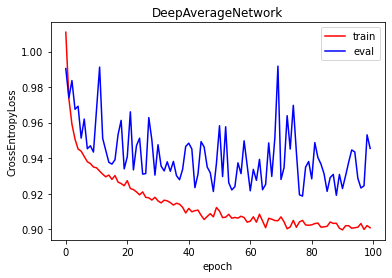

In [27]:
plt.plot(loss, color='red', label='train')
plt.plot(loss_eval, color='blue', label='eval')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('CrossEntropyLoss')
plt.title('DeepAverageNetwork')
plt.show()

In [28]:
# test
score, predictions = evaluate(model, criterion, test_loader, device, return_predictions=True)
print(f'Функция потерь на тестовой выборке: {score}')
softmax = nn.Softmax(dim=1)
y_true = predictions['true']
y_pred = softmax(predictions['pred'])
y_pred = torch.argmax(y_pred, dim=1)
print(sklearn.metrics.classification_report(y_true, y_pred))

100%|████████████████████████████████████████| 384/384 [00:02<00:00, 168.83it/s]


epoch loss 0.9983900353933374
Функция потерь на тестовой выборке: 0.9983900353933374
              precision    recall  f1-score   support

         0.0       0.59      0.08      0.14      3972
         1.0       0.52      0.91      0.66      5937
         2.0       0.51      0.31      0.38      2375

    accuracy                           0.52     12284
   macro avg       0.54      0.43      0.40     12284
weighted avg       0.54      0.52      0.44     12284



In [29]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

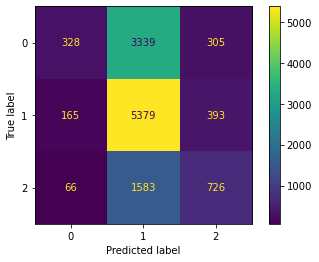

In [30]:
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
disp.plot()

Что-то метрики не очень хорошие